### Monitoring of the water extent of Lake Neusiedl and the Lacken:

#### Data Preparation

#### Libraries

In [182]:
import os
import glob
from osgeo import gdal
import pprint
import numpy as np
import matplotlib.pyplot as plt
from yeoda.datacube import DataCubeReader, DataCubeWriter
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
import pandas as pd
import time
import rasterio
import glob
from rasterio.plot import show
import rasterio
import numpy as np
from rasterio.merge import merge
from rasterio.plot import show
from osgeo import gdal
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
import warnings
import numpy as np
import glob
from six.moves import xrange
import scipy.ndimage as ndi
import os
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
import torch
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
import shutil
import albumentations as A
import sys
from PIL import Image, ImageOps, ImageFile
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [183]:
# pip install scipy
seed = 42


def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)


set_seed(seed)

In [184]:

warnings.simplefilter(action='ignore', category=FutureWarning)


In [181]:
# del sys.modules['data_func']



#### Reading Data

In [147]:
tile_1 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1"
tile_1 = glob.glob(os.path.join(tile_1, "*"))

In [148]:
tile_2 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N015T1"
tile_2 = glob.glob(os.path.join(tile_2, "*"))

In [149]:

mask1 = r"./e11739391/reference/EQUI7_EU010M/E052N015T1"
mask1 = glob.glob(os.path.join(mask1, "*"))

mask2 = r"./e11739391/reference/EQUI7_EU010M/E053N015T1"
mask2 = glob.glob(os.path.join(mask2, "*"))

In [150]:

dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
tile1_reader = DataCubeReader.from_filepaths(tile_1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile1_reader.file_register.head(5)

,filepath,var_name,data_version,tile_name,sensor_field,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,GMR40,V1M0R01,E053N015T1,S1AIWGRDH,2022-09-22 16:42:50
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,GMR40,V1M0R01,E053N015T1,S1AIWGRDH,2022-01-17 05:02:29
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,GMR40,V1M0R01,E053N015T1,S1AIWGRDH,2022-06-10 05:02:33
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,GMR40,V1M0R01,E053N015T1,S1AIWGRDH,2022-04-11 05:02:29
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,GMR40,V1M0R01,E053N015T1,S1AIWGRDH,2022-12-07 05:02:12


In [151]:

tile2_reader = DataCubeReader.from_filepaths(tile_2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile2_reader.file_register.head(5)

,filepath,var_name,data_version,tile_name,sensor_field,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,GMR40,V1M0R01,E052N015T1,S1AIWGRDH,2022-06-10 05:02:08
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,GMR40,V1M0R01,E052N015T1,S1AIWGRDH,2022-12-07 05:02:37
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,GMR40,V1M0R01,E052N015T1,S1AIWGRDH,2022-10-20 05:02:13
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,GMR40,V1M0R01,E052N015T1,S1AIWGRDH,2022-02-10 05:02:04
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,GMR40,V1M0R01,E052N015T1,S1AIWGRDH,2022-03-06 05:02:03


In [152]:
tile1_reader.file_register.sort_values(by='time')['time'].unique()

<DatetimeArray>
['2022-01-17 05:02:04', '2022-01-17 05:02:29', '2022-02-10 05:02:04',
 '2022-02-10 05:02:29', '2022-03-06 05:02:03', '2022-03-06 05:02:28',
 '2022-04-11 05:02:04', '2022-04-11 05:02:29', '2022-05-17 05:02:05',
 '2022-05-17 05:02:30', '2022-06-10 05:02:08', '2022-06-10 05:02:33',
 '2022-07-24 16:42:48', '2022-07-24 16:43:13', '2022-08-05 16:42:49',
 '2022-08-05 16:43:14', '2022-09-22 16:42:50', '2022-09-22 16:43:15',
 '2022-10-20 05:02:13', '2022-10-20 05:02:38', '2022-11-01 05:02:13',
 '2022-11-01 05:02:38', '2022-12-07 05:02:12', '2022-12-07 05:02:37']
Length: 24, dtype: datetime64[ns]

In [153]:
mask1_reader = DataCubeReader.from_filepaths(mask1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
mask2_reader = DataCubeReader.from_filepaths(mask2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")

In [154]:
mask2_reader.file_register.head(5)

,filepath,var_name,data_version,tile_name,sensor_field,time
0,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,MASK,None,E053N015T1,None,2022-08-05
1,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,MASK,None,E053N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,MASK,None,E053N015T1,None,2022-04-11
3,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,MASK,None,E053N015T1,None,2022-09-22
4,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,MASK,None,E053N015T1,None,2022-07-24


In [155]:
mask1_reader.file_register.head(5)

,filepath,var_name,data_version,tile_name,sensor_field,time
0,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,MASK,None,E052N015T1,None,2022-05-17
1,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,MASK,None,E052N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,MASK,None,E052N015T1,None,2022-10-20
3,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,MASK,None,E052N015T1,None,2022-12-07
4,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,MASK,None,E052N015T1,None,2022-05-17


#### Merging files

In [156]:
df_concat = pd.concat([tile1_reader.file_register, tile2_reader.file_register], axis=0)

In [ ]:
df_concat.head(5)

In [ ]:
merge_files_and_split(df_concat, 'VV')

In [ ]:
merge_files_and_split(df_concat, 'VH')

In [ ]:
df_concat_mask = pd.concat([mask1_reader.file_register, mask2_reader.file_register], axis=0)

In [ ]:
merge_files_and_split(df_concat_mask, notmask=False)

In [163]:
test_mask = "./train_mask/VV_mask_2022-02-10_merged.tiff"
test_img = "./train/VH_2022-02-10_merged.tiff"

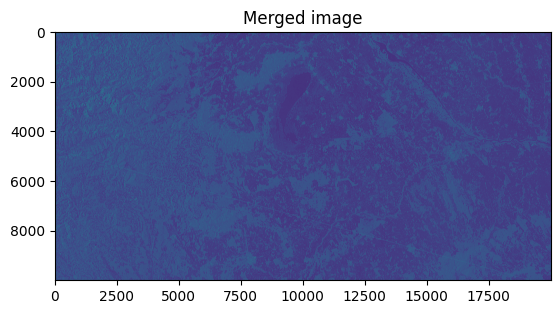

In [164]:
x = rasterio.open(test_img)
image_data = x.read(1)
plt.imshow(image_data)
plt.title("Merged image")

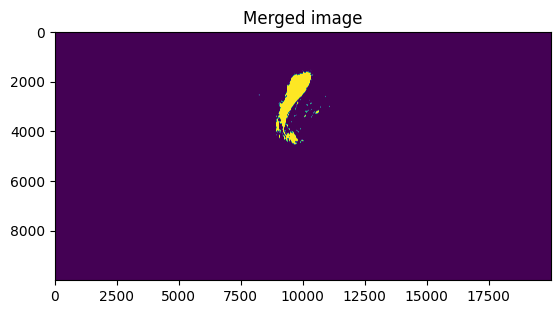

In [165]:
x = rasterio.open(test_mask)
image_data = x.read(1)
plt.imshow(image_data)
plt.title("Merged image")
plt.figsize = (4, 6)

In [ ]:
# Image.MAX_IMAGE_PIXELS = None
# ImageFile.LOAD_TRUNCATED_IMAGES = True


In [166]:
train = "./train/*.tiff"
mask_train = "./train_mask/*.tiff"
test = "./test/*.tiff"
mask_test = "./test_mask/*.tiff"
val = "./val/*.tiff"
mask_val = "./val_mask/*.tiff"

In [167]:
make_list(train, mask_train, 'train')
make_list(test, mask_test, 'test')
make_list(val, mask_val, 'val')

### Data Augmentation

In [185]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [186]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ToTensorV2()])

train_set = ImageDataset('./train/', './train_mask', train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)

In [187]:
# image, mask = next(iter(trainloader))

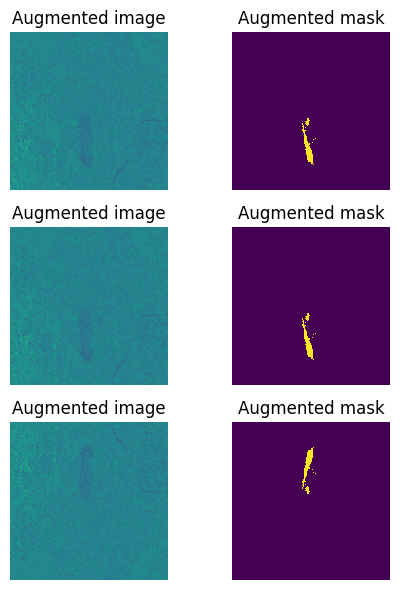

In [188]:

visualize_augmentations(train_set, idx=1, samples=3)

In [189]:
val_set = ImageDataset('./val/', './val_mask', None)
valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True)
test_set = ImageDataset('./test/', './test_mask', None)
testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True)